In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import uniform, exponential
import numpy as np
import pandas as pd
import seaborn as sb
from lifelines.utils import survival_table_from_events
from lifelines.plotting import plot_lifetimes

## plot/figure defaults
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['figure.titlesize'] = 'large'


In [2]:
# (prep for example - borrowed from http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html)
from numpy.random import uniform, exponential
import numpy as np

## example of censored data
from lifelines.plotting import plot_lifetimes
def plot_example():
    N = 25
    current_time = 10

    actual_lifetimes = np.array([[exponential(12), exponential(5)][uniform()<0.3] for i in range(N)])
    observed_lifetimes = np.minimum(actual_lifetimes, current_time)
    observed = actual_lifetimes < current_time
    fig = plt.figure()
    _ = plt.xlim(0, 25)
    _ = plt.vlines(10, 0, 30, lw=2, linestyles="--")
    _ = plt.xlabel('time')
    _ = plt.title('Births and deaths of a hypothetical population, censored at $t=10$', size=20)    
    _ = plot_lifetimes(lifetimes=observed_lifetimes, event_observed=observed)



In [14]:
## prep example plot for hazard <> Survival curves
def plot_survival_exp(N, censor_time, rate):

    sample_data = pd.DataFrame({
            't': np.linspace(0, censor_time, num=N),
            })
    sample_data['hazard'] = rate
    sample_data['cum_hazard'] = rate*sample_data.t
    sample_data['Survival'] = np.exp(-1 * rate * sample_data.t)
    fig = plt.figure()
    _ = plt.subplot(131)
    _ = plt.plot(sample_data.t, sample_data.hazard, 'b')
    _ = plt.title('Hazard $\lambda(t)$', size=20)
    _ = plt.xlabel('time')
    _ = plt.subplot(132)
    _ = plt.plot(sample_data.t, sample_data.cum_hazard, 'r')
    _ = plt.title('Cum. hazard $H(t)$', size=20)
    _ = plt.xlabel('time')
    _ = plt.subplot(133)
    _ = plt.plot(sample_data.t, sample_data.Survival, 'g')
    _ = plt.title('Survival $S(t)$', size=20)
    _ = plt.xlabel('time')
    


# Survival Modeling in Stan

 -- TODO insert image here 
 

# a very brief introduction

Survival analysis typically involves **time to event** as the outcome of interest

Typical applications include:
* biomedical research (time to clinical event or death)
* digital marketing (time to click or KPI)
* machine (time to mechanical failure)
* psychology (e.g. studies of delayed gratification)
* ... etc


## key terms
* censoring: when an event isn't observed, but we know 
   - it happened after time `b` (right censoring)
   - it happened before time `a` (left censoring)
   - it happened between times `a` and `b` (interval censoring)

Survival analysis typically makes an assumption of *non-informative censoring*. 

If this assumption holds, it means that the true event time (if it were to be observed) is unrelated to the censored time.

In a context of a well-designed clinical trial, this assumption is addressed by the study design which imposes an independent censoring process. 

For example, it's not uncommon for follow-up time to be truncated after a predetermined time $t=10$ for all patients.

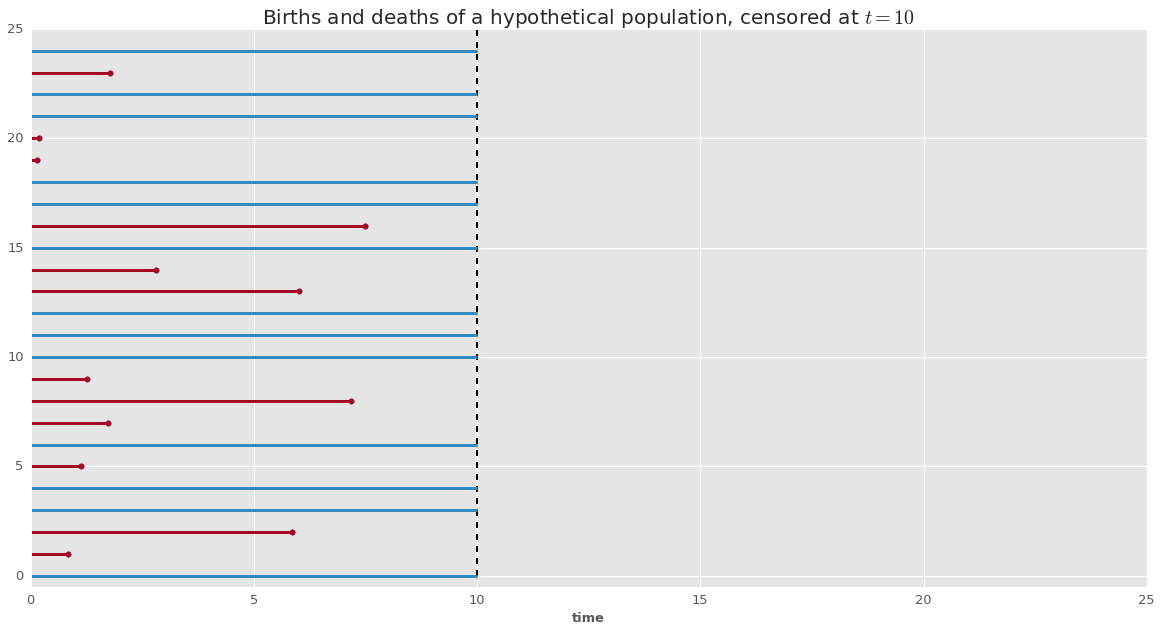

In [4]:
plot_example()

*however*, this assumption can sometimes be violated if, for example, less healthy patients are more likely to drop out of the study early.

## key terms (cont'd)

* failure event: the outcome event of interest
* survival: not failure
* hazard: risk for failure events

**Survival**

We first define a *Survival* function $S$ as the probability of surviving to time $t$:

  $$ S(t)=Pr(T>t) $$

where $T$ is the true survival time.

**hazard**

We also define the instantaneous *hazard* function $\lambda$ as the probability of a failure event occuring in the interval [$t$, $t+\delta t$], given survival to time $t$:


  $$ \lambda(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le T \le t + \delta t | T > t)}{\delta t} $$

Which is equal to 

  $$ \lambda(t) = \frac{-S'(t)}{S(t)} $$

Solving this 

  $$ \lambda(t) = \frac{-S'(t)}{S(t)} $$
  
yields the following:

  $$ S(t) = \exp\left( -\int_0^t \lambda(z) dz \right) $$

which provides a useful way for us to switch from modeling *hazards* to modeling *Survival*.

The integral in this equation is also sometimes called the *cumulative hazard*, here noted as $H(t)$.

  $$ H(t) = \int_0^t \lambda(z) dz $$

It's worth pointing out that, by definition, the cumulative hazard (estimating $Pr(T \lt t)$) is the complementary c.d.f of the Survival function (which estimates $Pr(T \ge t)$).


As an example, suppose we consider a simple *hazard* function $\lambda(t)$ as constant over time. 

E.g. 
  $$ \lambda(t) = a $$

Cumulative hazard ($H$) would be linearly increasing : 

  $$ H(t) = \int_0^t \lambda(z) dz = at $$

And the *Survival* function would be exponentially decreasing as a function of $t$ :

  $$ S(t) = \exp\left( -\int_0^t \lambda(z) dz \right) = \exp ( − a t ) $$



Graphically, this would look like the following: 

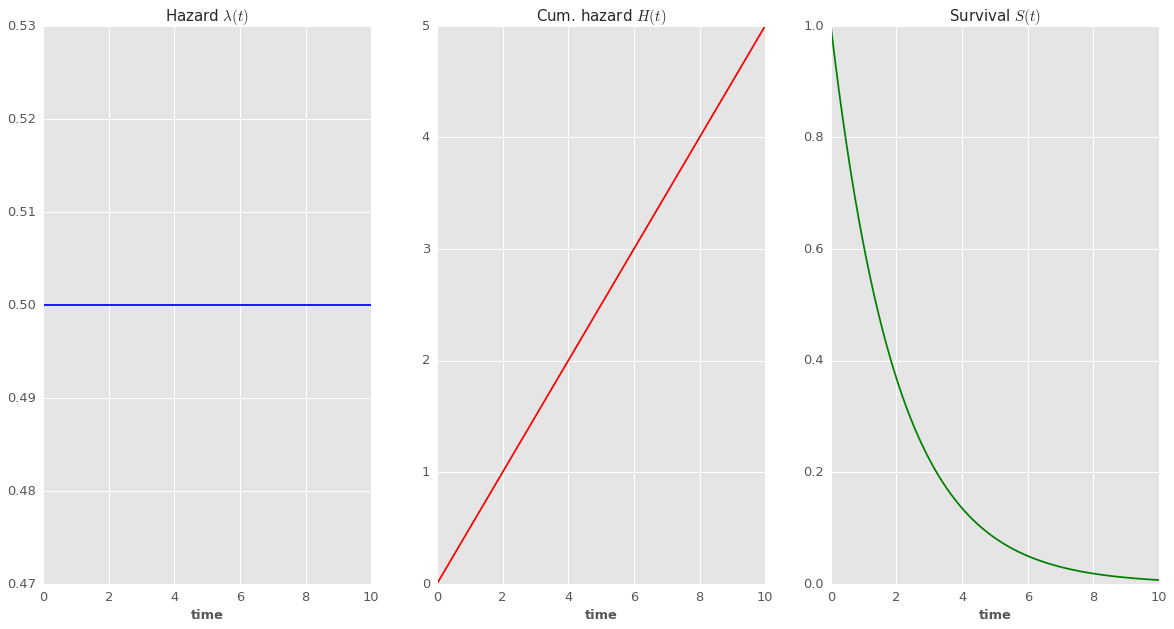

In [5]:
plot_survival_exp(N = 1000, censor_time = 10, rate = 0.5)

In [6]:
## prep simulate-data example under Exponential model
def plot_cum_survival(t, event):
    # at each time t, calculate the cumulative survival
    cum_survival = survival_table_from_events(t, event)
    cum_survival.reset_index(0, inplace=True)
    cum_survival.rename(columns = {'at_risk': 'Survival', 'event_at': 't'}, inplace=True)
    # create figure
    fig = plt.figure()
    _ = plt.plot(cum_survival.t, cum_survival.Survival, 'rs')
    _ = plt.xlabel('time')
    return(cum_survival)


We can also simulate survival times for a population under this fairly simple model.

In [7]:
# define a function to simulate data
def simulate_exp_survival_data(N, censor_time, rate):
    ## simulate true lifetimes (t) according to exponential model
    sample_data = pd.DataFrame({
            'true_t': np.random.exponential((1/rate), size=N) 
            })
    ## censor observations at censor_time
    sample_data['t'] = np.minimum(sample_data['true_t'], censor_time)
    sample_data['event'] = sample_data['t'] >= sample_data['true_t']
    return(sample_data)

In [19]:
# simulate data assuming constant hazard over time of 0.5
df = simulate_exp_survival_data(N = 100, censor_time = 6, rate = 0.5)
df.head()

,true_t,t,event
0,6.787904,6.000000,False
1,0.148297,0.148297,True
2,0.419113,0.419113,True
3,0.210082,0.210082,True
4,4.313918,4.313918,True


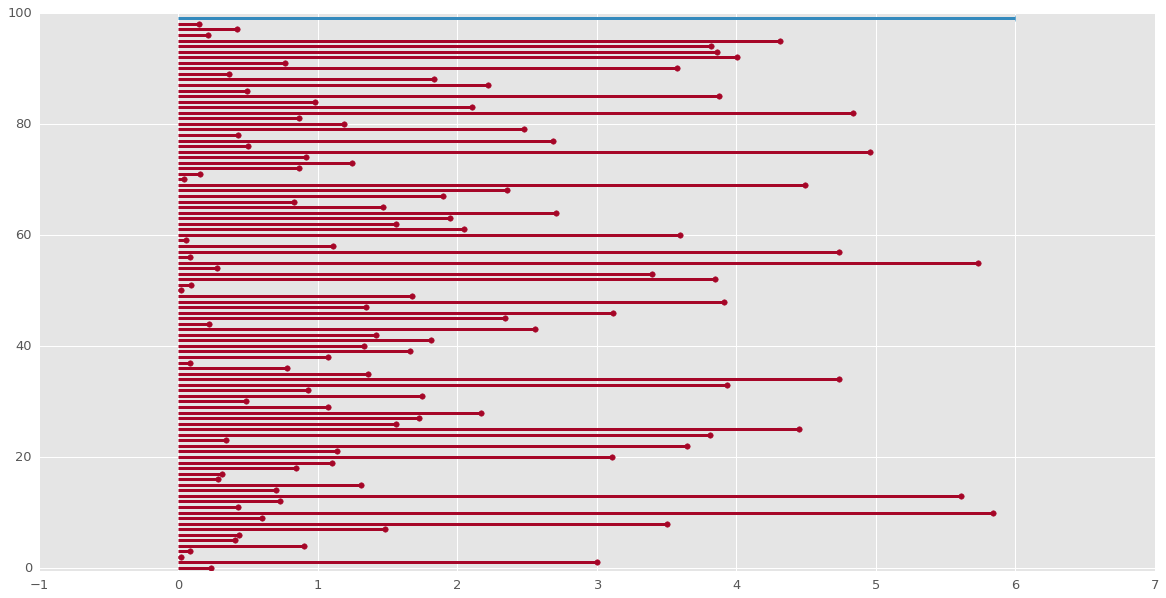

In [20]:
# plot lifelines for this simulated sample
plot_lifetimes(event_observed=df.event, lifetimes=df.t)

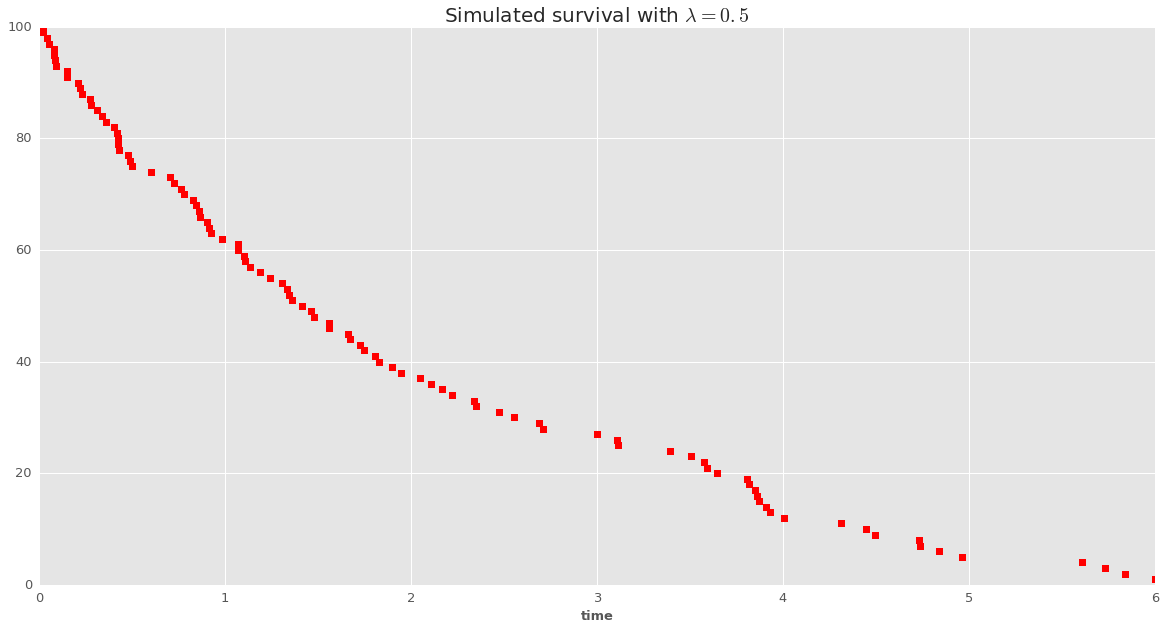

In [21]:
# calculate number of people surviving at each time T
# plot Survival to time t given simulated data
a = plot_cum_survival(df.t, df.event)
_ = plt.title('Simulated survival with $\lambda={}$'.format(0.5), size=20)    

Now, overlay computed Survival from simulated data with estimated c.d.f 

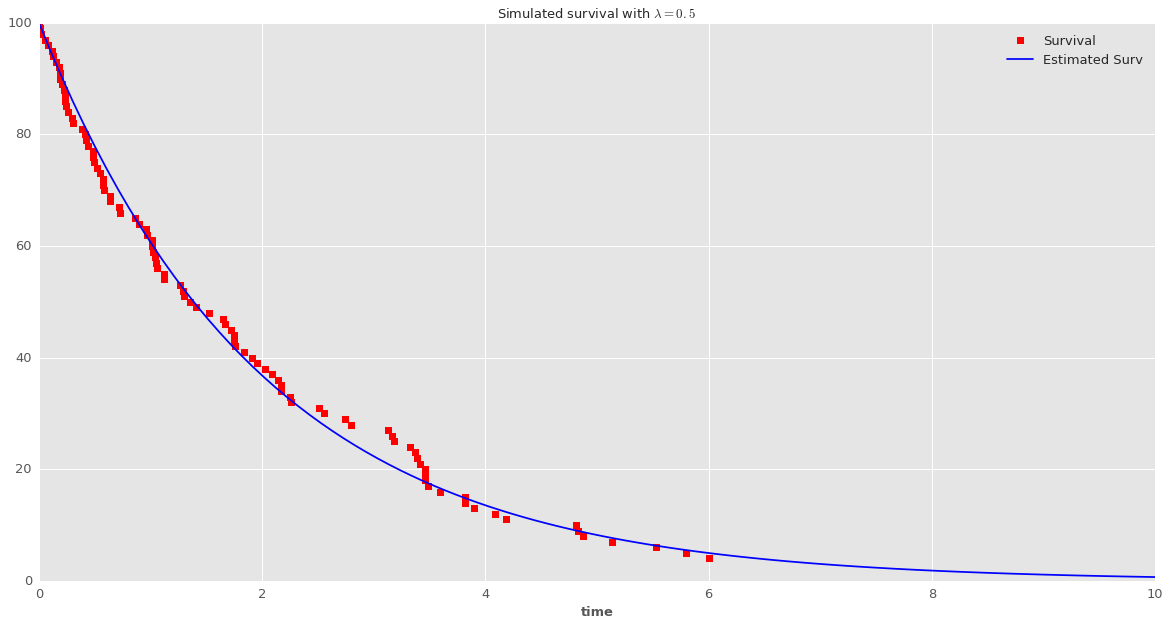

In [23]:
# re-create earlier plot
df = simulate_exp_survival_data(N = 100, censor_time = 6, rate = 0.5)
a = plot_cum_survival(df.t, df.event)
_ = plt.title('Simulated survival with $\lambda={}$'.format(0.5))

## overlay c.d.f. estimate as exp(-at)
test = pd.DataFrame([{
            't': t,
            'Estimated Surv': np.exp(-1 * 0.5 * t)
        } for t in np.linspace(0, 10, num=100)])
_ = plt.plot(test.t, 100*test['Estimated Surv'], 'b')
_ = plt.legend()

# the likelihood

The data for survival analysis typically constitute a set of observed pairs: [`t`, `status`] for each subject, where 

* `t` is the survival time (last time a subject was observed alive)
* `status` is a binary (T/F or 1/0) indicator for whether the failure event occurred at time `t`.



The likelihood for each of these observations reflects the joint probability of 

* surviving to time `t`,
* (if an event occurred) having an failure event at time `t` (or in the interval [$t$, $t+\delta t$])

   $$ L = $$ 



In [11]:
## example data from TCGA-BLCA cohort
import pandas as pd
import io
import requests
from cohorts.utils import strip_column_names
url = 'http://www.cbioportal.org/webservice.do?cmd=getClinicalData&case_set_id=blca_tcga_all'
s = requests.get(url).content
c = pd.read_csv(io.StringIO(s.decode('utf-8')), delimiter='\t')
df = c.rename(columns=strip_column_names(c.columns))
df = df.dropna(subset=['os_months','os_status'])

In [12]:
## inspect key explanatory variables
df.loc[:,['case_id', 'os_status', 'os_months', 'age', 'histological_subtype',
         'dfs_status', 'dfs_months']].head()

,case_id,os_status,os_months,age,histological_subtype,dfs_status,dfs_months
0,TCGA-GV-A40G-01,LIVING,19.05,77.0,Non-Papillary,DiseaseFree,19.05
1,TCGA-E7-A7DU-01,LIVING,0.92,73.0,Papillary,DiseaseFree,0.92
2,TCGA-CF-A5UA-01,LIVING,11.99,67.0,Papillary,DiseaseFree,11.99
3,TCGA-FD-A5BT-01,DECEASED,10.78,84.0,Non-Papillary,NaN,NaN
4,TCGA-DK-A3X1-01,LIVING,66.00,78.0,Non-Papillary,DiseaseFree,66.00


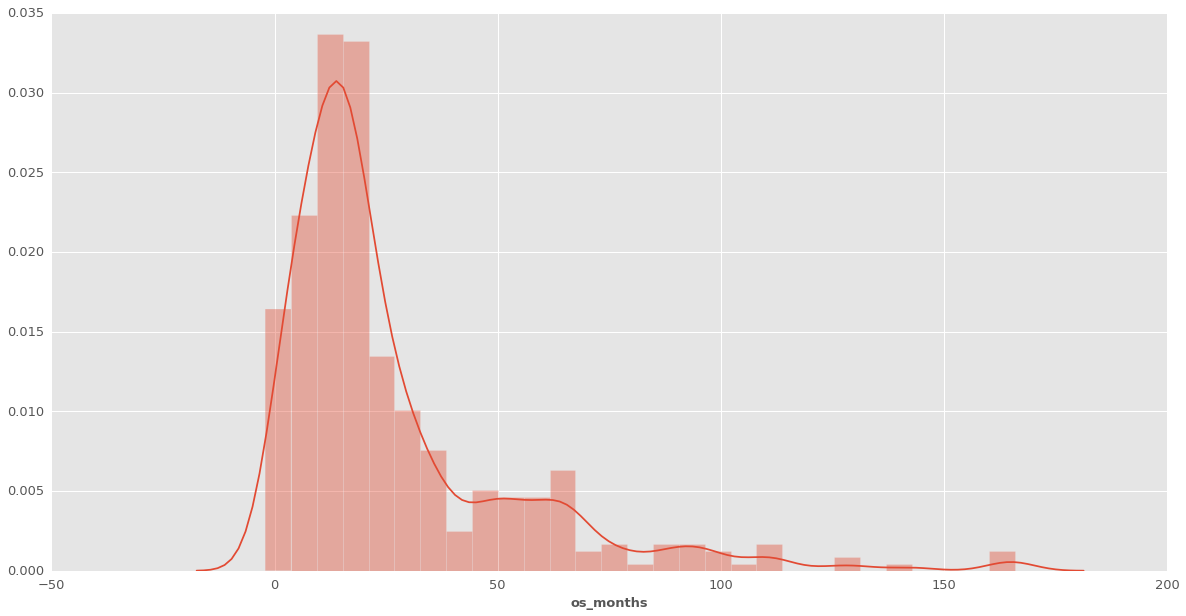

In [13]:
## distribution of survival times
import seaborn as sb
sb.distplot(df.os_months)